
## Stock choice and GenAI Conversation

#### Conversation Strategy:
Instead of just asking something basic like “give us three stocks from the utilities sector,” we tried to have more of a back-and-forth conversation so the tool actually understood what we were looking for.
Some of the things we asked about were:

- Which stocks in each sector have long, consistent price history (since the project doesn’t allow newly listed stocks)?

- Whether the stocks are considered “stable” vs. “risky”

- Which stocks tend to have clean, price data

- What are a few candidates per sector with concrete reasons (dividends, size, volatility)

We also cross-checked that the stocks were actually in the S&P 500.

From that conversation, we narrowed down each sector and confirmed the final list with follow-up questions so we weren’t just blindly trusting the first answer. We made the final checks ourselves by going to stock websites like StockAnalysis and checked the requirements manually as well.

#### Stocks

- NextEra Energy (NEE) (Utilities)
  - One of the largest electric power and energy companies in North America, NEE gives our portfolio exposure to a long standing utility company that also has a strong focus on renewables which may be the future of energy
- The Southern Company (SO) (Utilities)
  - Large U.S. regulated utility holding company that supplies gas and electricity to places in the southern United States, this is another steady balanced utility company
- American Waterworks (AWK) (Utilities)
  - AWK is the largest regulated water and wastewater utility company in the United States, this diversified our portfolio to go beyond just energy utility companies
- JPMorgan Chase (JPM) (Financials)
  - Very well known global financial institution, we chose this because it is a very longstanding and trustworthy company that has been around for a while
- Visa (V) (Financials)
  - Operates one of the largest electronic payment methods in the world, we chose V because it holds a big part of the financial infastructure side of the sector
- Chubb (CB) (Financials)
  - Global financial insurance company known for its insurance policies on various things, allowed another unqiue aspect in our portfolio besides just soley banking financial companies (diversification)
- Linde plc (LIN) (Materials)
  - Leading global industrial gases company that supplies oxygen, nitrogen, hydrogen, and other gases, we chose this company because it has had a history of high growth diversified stock
- Freeport-McMoRan (FCX) (Materials)
  - Huge industrial metals company known for copper, it allows for a more selling driven company approach that can potentially allow for higher returns
- Sherwin-Williams (SHW) (Materials)
  - Well known paint and coating company that delivers worldwide, exposes the portfolio to the painting business instead of just gasses and metals

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install yfinance
import yfinance as yf

# Downloading Historical Price Data
In this next cell, we download the daily stock prices from Yahoo Finance from January 1, 2019 through December 31, 2023.
We made sure this wasn’t hard-coded by writing a loop that pulls each ticker from our list.

We store all adjusted close prices in one DataFrame and then compute daily percent returns, dropping any missing days so our data is clean before going into MPT.

In [ ]:
tickers_list = ['NEE', 'SO', 'AWK', 'JPM', 'V', 'CB', 'LIN', 'FCX', 'SHW']

utilities = ['NEE', 'SO', 'AWK']
financials = ['JPM', 'V', 'CB']
materials = ['LIN', 'FCX', 'SHW']

sector_groups = {
    'Utilities': utilities,
    'Financials': financials,
    'Materials': materials
}

start = "2019-01-01"
end   = "2023-12-31"

dow_prices = {}
for t in tickers_list:
    try:
        df = yf.download(t, start=start, end=end, interval="1d", progress=False, auto_adjust=False)
        if not df.empty:
            dow_prices[t] = df
        else:
            print(f"Warning: no data returned for {t}")
    except Exception as e:
        print(f"Failed {t}: {e}")


In [ ]:
prep_data = pd.DataFrame(dow_prices['NEE']['Adj Close']).rename(columns = {'Adj Close':'NEE'})

for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['Adj Close'])

In [ ]:
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
return_data.dropna(inplace=True)

# Plotting Daily Returns
Here we plot the daily return series for all nine stocks to see about how volatile each stock is. These graphs show that the stocks' behaviors aren't all the same and that we loaded the data for each stock correctly. We can also see that nothing looks obviously wrong so far before we begin building our optimization model.

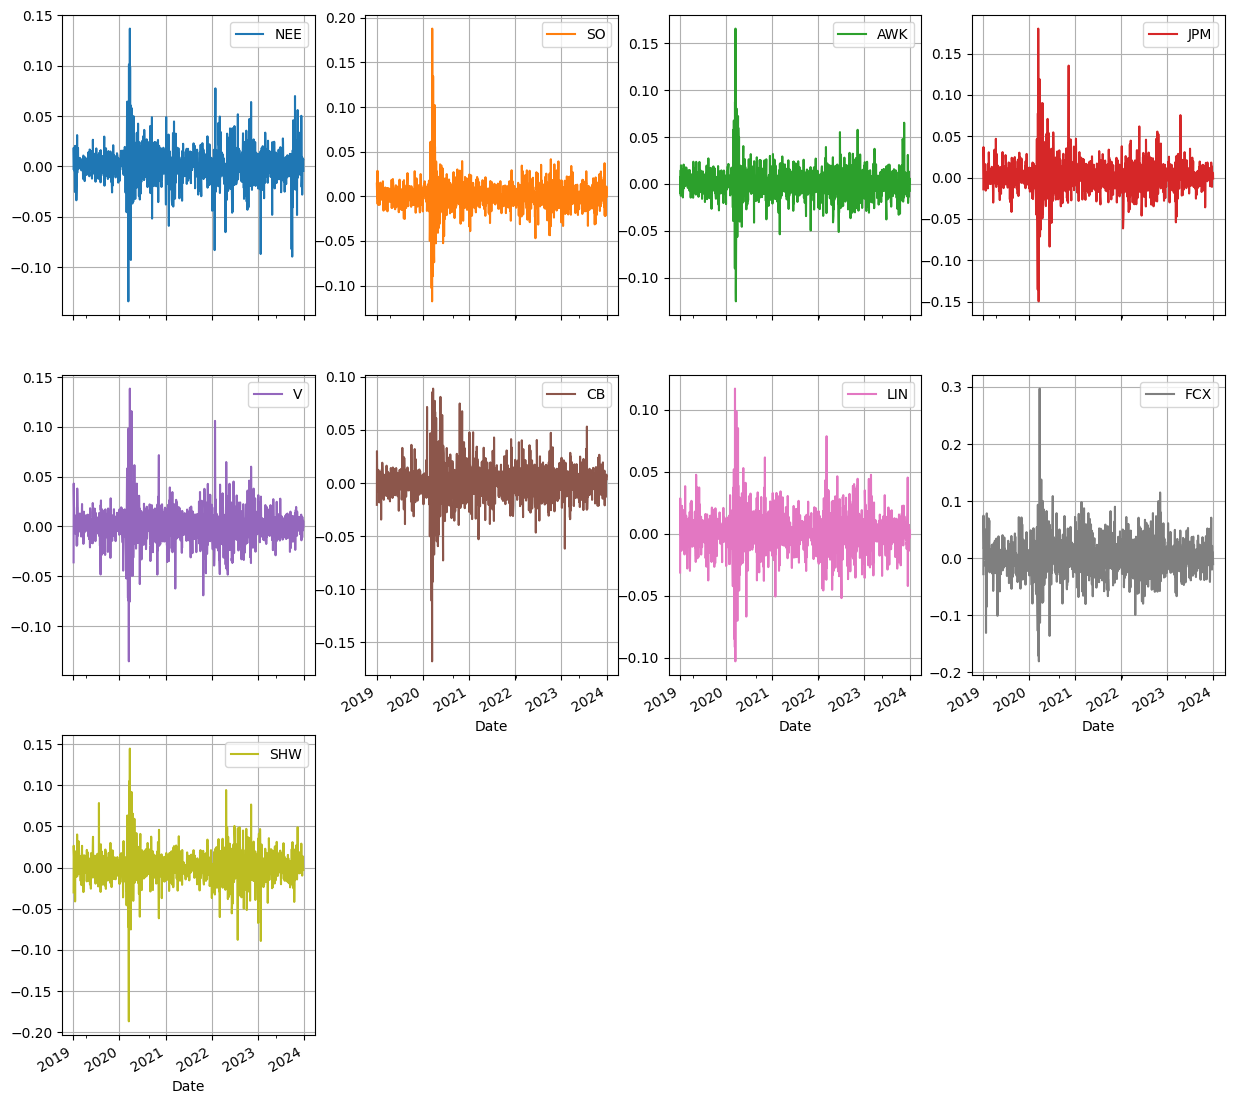

In [ ]:
return_data.plot(subplots=True,
        grid=True,
        layout=(3,4),
        figsize=(15,15))
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

# Time Series Graphs

Here we created three graphs graphing return ratio to time. There is a graph for each sector with each line representing a stock from the sector. This shows if the stock's prices increased or decreased from in the range of 2019-2023.

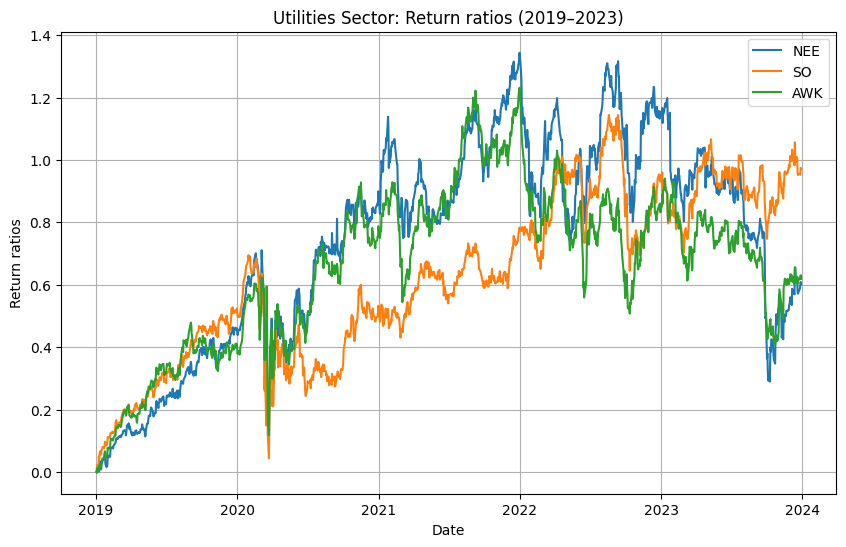

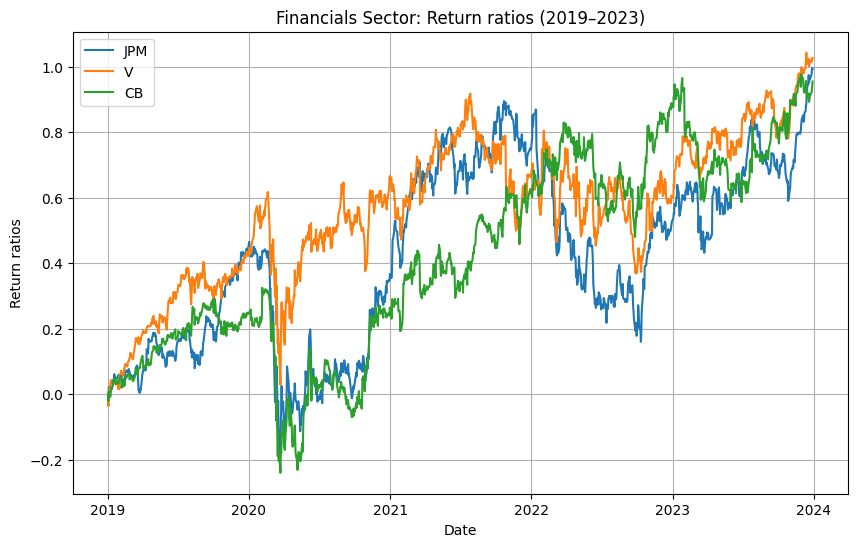

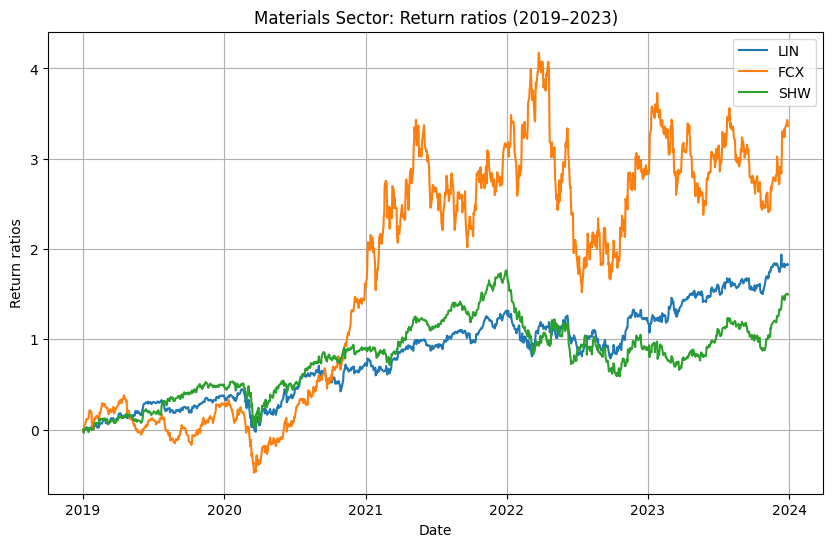

In [ ]:
for sector_name, tickers in sector_groups.items():
    plt.figure(figsize=(10,6))
    for ticker in tickers:
        # Calculate cumulative return
        # Normalize the Adj Close prices to start from 1
        normalized_prices = dow_prices[ticker]['Adj Close'] / dow_prices[ticker]['Adj Close'].iloc[0]
        # Calculate cumulative return (growth from initial price)
        Retrun_ratio = normalized_prices - 1
        plt.plot(dow_prices[ticker].index, Retrun_ratio, label=ticker)
    plt.legend()
    plt.title(f'{sector_name} Sector: Return ratios (2019–2023)')
    plt.ylabel('Return ratios')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

For the utilities sector graph, all three stocks moved mostly together following global events like COVID-19, but followed their own paths during other times. The Southern Company stock (SO) ended around 1.0, which means it didn't really change in terms of return ratio. Stocks like NextEra Energy (NEE) and American Waterworks (AWK) had a 0.6 cumulative return in 2023, which means they decresed by 40%.

For the financials sector graph, it just about started and ended at the same cumulative return spot from 2019 to 2024. They all reached 1.0, which means their return didn't really change.

For the materials sector, Freeport-McMoRan (FCX) showed a really surprising return as it reached a return of about 3.5, meaning it showed an increase of 250% which is really impressive. The Linde plc (LIN) stock also did pretty well, resulting in a about 1.75 return rate meaning it went up by 75%. Sherwin-Williams (SHW)wasn't far off either, ending with a 1.5 return rate, meaning it went up b 50%. All these stocks performed much better than we expected as compared to the other sectors where we thought we would see a higher cumulative return.

# Modern Portfolio Theory

#### Setting Up Pyomo and the Optimization Model

Here we import Pyomo and start to set up the IPOPT solver.

In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 33.9MB/s]


# Covariance Matrix and Average Returns
Before we can begin the Model, we calculate
- The covariance matrix of the returns of the stocks
- The average return for each stock

The covariance matrix allows us to see how related the stocks are. In our case none of the stocks have a negative covariance. A negative covariance would essentially mean that as one stock goes up the other would go down. Since all of the covariances here are positive we can expect our chosen stocks to move in a similar direction over time.

In [ ]:
# creating covariance table on stock return dataframe
df_cov = return_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n')

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = return_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
          NEE        SO       AWK       JPM         V        CB       LIN  \
NEE  0.000332  0.000217  0.000227  0.000136  0.000138  0.000140  0.000145   
SO   0.000217  0.000274  0.000219  0.000149  0.000139  0.000155  0.000129   
AWK  0.000227  0.000219  0.000292  0.000123  0.000134  0.000132  0.000134   
JPM  0.000136  0.000149  0.000123  0.000404  0.000221  0.000240  0.000210   
V    0.000138  0.000139  0.000134  0.000221  0.000312  0.000177  0.000187   
CB   0.000140  0.000155  0.000132  0.000240  0.000177  0.000325  0.000168   
LIN  0.000145  0.000129  0.000134  0.000210  0.000187  0.000168  0.000280   
FCX  0.000171  0.000147  0.000117  0.000376  0.000296  0.000253  0.000301   
SHW  0.000163  0.000140  0.000152  0.000166  0.000184  0.000152  0.000175   

          FCX       SHW  
NEE  0.000171  0.000163  
SO   0.000147  0.000140  
AWK  0.000117  0.000152  
JPM  0.000376  0.000166  
V    0.000296  0.000184  
CB   0.000253  0.000152  
LIN  0.000301  0.000175  
FC

# Defining Variables
Here we create a concrete model along with nine variables, one for each stock. Each variable will represent the proportion of our portfolio the stock will be allocated to, and has bounds of 0 and 1 since allocation cannot be negative and the percentages must add up to 1. In the next cell we add the constraints that the sum of the allocations must add up to 1, so the modelwill be investing 100% of the "money" we have. Along with creating the constraint we also create the objective function where we add up how much of each stock we have multiplied by the returns from that stock, and we tell the model tp maximize the objective function in order to find where we can make the most money.

In [ ]:
m = ConcreteModel()

# defining variables
# each one is a stock (NEE, SO, AWK, JPM, V, CB, LIN, FCX, SHW)
m.NEE = Var(within=NonNegativeReals, bounds=(0,1))
m.SO = Var(within=NonNegativeReals, bounds=(0,1))
m.AWK = Var(within=NonNegativeReals, bounds=(0,1))
m.JPM = Var(within=NonNegativeReals, bounds=(0,1))
m.V = Var(within=NonNegativeReals, bounds=(0,1))
m.CB = Var(within=NonNegativeReals, bounds=(0,1))
m.LIN = Var(within=NonNegativeReals, bounds=(0,1))
m.FCX = Var(within=NonNegativeReals, bounds=(0,1))
m.SHW = Var(within=NonNegativeReals, bounds=(0,1))

In [ ]:
# declare objective
m.objective = Objective(expr =
                        m.NEE*df_return[0] +
                        m.SO*df_return[1] +
                        m.AWK*df_return[2] +
                        m.JPM*df_return[3] +
                        m.V*df_return[4] +
                        m.CB*df_return[5] +
                        m.LIN*df_return[6] +
                        m.FCX*df_return[7] +
                        m.SHW*df_return[8],
                        sense=maximize) # yes, we want to MAX our returns!

# declare constraints
# 1. Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.NEE + m.SO + m.AWK + m.JPM + m.V + m.CB + m.LIN + m.FCX + m.SHW == 1)

/tmp/ipython-input-2727769639.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.NEE*df_return[0] +
/tmp/ipython-input-2727769639.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.SO*df_return[1] +
/tmp/ipython-input-2727769639.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.AWK*df_return[2] +
/tmp/ipython-input-2727769639.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

# Risk
Here we calculate total risk of the portfolio based on how much money we want to put in each stock. we do this by using the covariance matrix where we loop through every pair of stocks, i and j which multiply
- Allocation to stock i
- Covariance between stocks i and j
- Allocation to stock j

Adding upthese products gives the overall portfolio variance and is used in MPT to calculate portfolio risk

We then choose a maxiimum risk level (taken from the highest value in the covariance matrix) and create a list of at least 100 risk levels below our maximum risk. We will run our model with each of these risk levels to obtain different optimal allocations of our stocks depending on how much risk we want to have.

In [ ]:
# creating calculations table for calculate the risk
# 3. Calculate risk
def calc_risk(m):
  variables = m.NEE, m.SO, m.AWK, m.JPM, m.V, m.CB, m.LIN, m.FCX, m.SHW
  tickers = ['NEE', 'SO', 'AWK', 'JPM', 'V', 'CB', 'LIN', 'FCX', 'SHW']
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# 3. Max risk should be less than 0.01 <-- Get from cov matrix (highest value in cov matrix)
max_risk = 0.001286
# Sequence of risk levels
risk_limits = np.arange(0.00005, max_risk, 0.00001) # take tiny steps
risk_limits

array([5.00e-05, 6.00e-05, 7.00e-05, 8.00e-05, 9.00e-05, 1.00e-04,
       1.10e-04, 1.20e-04, 1.30e-04, 1.40e-04, 1.50e-04, 1.60e-04,
       1.70e-04, 1.80e-04, 1.90e-04, 2.00e-04, 2.10e-04, 2.20e-04,
       2.30e-04, 2.40e-04, 2.50e-04, 2.60e-04, 2.70e-04, 2.80e-04,
       2.90e-04, 3.00e-04, 3.10e-04, 3.20e-04, 3.30e-04, 3.40e-04,
       3.50e-04, 3.60e-04, 3.70e-04, 3.80e-04, 3.90e-04, 4.00e-04,
       4.10e-04, 4.20e-04, 4.30e-04, 4.40e-04, 4.50e-04, 4.60e-04,
       4.70e-04, 4.80e-04, 4.90e-04, 5.00e-04, 5.10e-04, 5.20e-04,
       5.30e-04, 5.40e-04, 5.50e-04, 5.60e-04, 5.70e-04, 5.80e-04,
       5.90e-04, 6.00e-04, 6.10e-04, 6.20e-04, 6.30e-04, 6.40e-04,
       6.50e-04, 6.60e-04, 6.70e-04, 6.80e-04, 6.90e-04, 7.00e-04,
       7.10e-04, 7.20e-04, 7.30e-04, 7.40e-04, 7.50e-04, 7.60e-04,
       7.70e-04, 7.80e-04, 7.90e-04, 8.00e-04, 8.10e-04, 8.20e-04,
       8.30e-04, 8.40e-04, 8.50e-04, 8.60e-04, 8.70e-04, 8.80e-04,
       8.90e-04, 9.00e-04, 9.10e-04, 9.20e-04, 9.30e-04, 9.40e

# Solving the Optimization
Now we can finally solve the optimization problem we created. Here for each risk value from the previous step we:

1. Update the risk constraint
2. Solve the optimization problem
3. If the solver can't find a feasible solution we skip the risk level
4. If the solver does find a feasible solution we save the allocation and the expected return at that risk level



In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition

# updating risk contraint for each limit and then solving the problem
param_analysis_dict = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # Remove constraint to avoid error messages
  if hasattr(m, 'total_risk'):
    m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  # result = SolverFactory('ipopt', executable=ipopt_executable).solve(m)
  result = SolverFactory('bonmin', executable=ipopt_executable).solve(m)

  # If solution is not feasible, ignore this run
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  result = result.write()

  # store our allocation proportions
  param_analysis_dict[r] = [m.NEE(), m.SO(), m.AWK(), m.JPM(), m.V(), m.CB(), m.LIN(), m.FCX(), m.SHW()]
  # store our returns, using value() to get the numerical result
  returns[r] =  value(m.NEE*df_return[0] + m.SO*df_return[1] + m.AWK*df_return[2] + m.JPM*df_return[3] + m.V*df_return[4] + m.CB*df_return[5] + m.LIN*df_return[6] + m.FCX*df_return[7] + m.SHW*df_return[8])

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -.inf
  Upper bound: .inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.019839763641357422
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==

/tmp/ipython-input-1766611319.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns[r] =  value(m.NEE*df_return[0] + m.SO*df_return[1] + m.AWK*df_return[2] + m.JPM*df_return[3] + m.V*df_return[4] + m.CB*df_return[5] + m.LIN*df_return[6] + m.FCX*df_return[7] + m.SHW*df_return[8])
/tmp/ipython-input-1766611319.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns[r] =  value(m.NEE*df_return[0] + m.SO*df_return[1] + m.AWK*df_return[2] + m.JPM*df_return[3] + m.V*df_return[4] + m.CB*df_return[5] + m.LIN*df_return[6] + m.FCX*df_return[7] + m.SHW*df_return[8])


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -.inf
  Upper bound: .inf
  Number of objectives: 1
  Number of constraints: 2
  Number of variables: 9
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.02848529815673828
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ===

# Plotting Allocations vs. Risk

The plot below shows each stock's allocations and how they change as the risk level increases to our maximum risk level. Through the graph we can see
- Low risk makes the portfolio more diverse
- High risk makes the portfolo more concentrated on one stock

We also used this graph to select a specific allocation to test our model in Part 3. We selected the allocations at a risk level of .00041 as it has at least three stocks above the required minimum allocation outlined in the project description. We pulled the allocations for each stock at that risk level by creating a new dataframe with only one row by using .loc[[0.00041]]

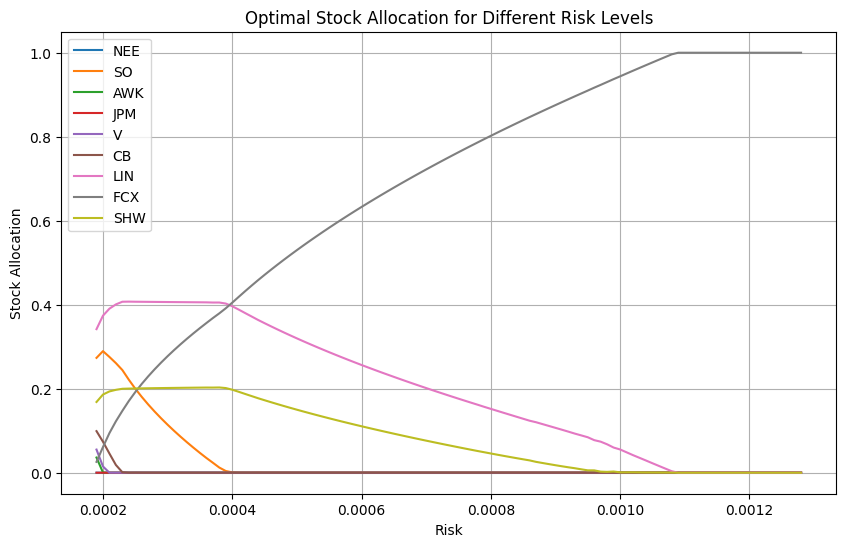

,NEE,SO,AWK,JPM,V,CB,LIN,FCX,SHW
0.00041,0.000005,0.000169,0.000006,0.000004,0.000005,0.000007,0.388413,0.418681,0.192708


In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis_dict, orient='index')
param_analysis.columns = ['NEE', 'SO', 'AWK', 'JPM', 'V', 'CB', 'LIN', 'FCX', 'SHW']
param_analysis.plot(figsize=(10,6))
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk')
plt.ylabel('Stock Allocation')
plt.grid(True)
plt.show()
param_analysis.loc[[.00041]] # Allocation values we are going to use

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward) # we aren't allowed to name our value 'return' - this is a reserved name.

[np.float64(0.00018999999999999998), np.float64(0.00019999999999999998), np.float64(0.00020999999999999998), np.float64(0.00021999999999999998), np.float64(0.00022999999999999998), np.float64(0.00023999999999999998), np.float64(0.00025), np.float64(0.00026), np.float64(0.00027), np.float64(0.00028), np.float64(0.00029), np.float64(0.00030000000000000003), np.float64(0.00031), np.float64(0.00031999999999999997), np.float64(0.00033), np.float64(0.00034), np.float64(0.00035), np.float64(0.00035999999999999997), np.float64(0.00037), np.float64(0.00038), np.float64(0.00039), np.float64(0.00039999999999999996), np.float64(0.00041), np.float64(0.00042), np.float64(0.00043), np.float64(0.00043999999999999996), np.float64(0.00045), np.float64(0.00046), np.float64(0.00047), np.float64(0.00047999999999999996), np.float64(0.00049), np.float64(0.0005), np.float64(0.0005099999999999999), np.float64(0.00052), np.float64(0.00053), np.float64(0.00054), np.float64(0.00055), np.float64(0.00056), np.float

# Efficient Frontier Plot
The final plot shows the eexpected return vs. risk. The curve rises quickly before eventually flattening out and hitting a plateau, mathicng what is expected out of MPT. This makes sense as after a certain point taking on more risk does not significantly increase expected return.

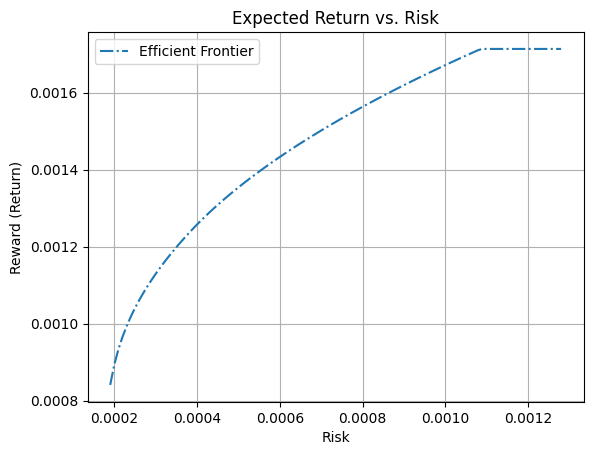

In [ ]:
# plot! pylab makes it easy
from pylab import *
plt.plot(risk, reward, '-.', label = "Efficient Frontier")
plt.title('Expected Return vs. Risk')
plt.xlabel('Risk')
plt.ylabel('Reward (Return)')
plt.legend()
plt.grid(True)
plt.show()

# Investment Strategies

# Buy and Hold for MPT portfolio
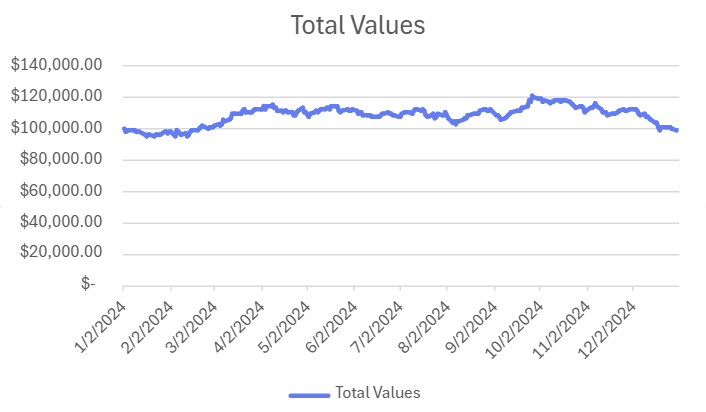

In our buy and hold strategy, we noticed that initially our investment hits a small dip early in the year and is then followed by a sustained period of growth with moderate fluctuations from the month of March up until July. In this span of time our portfolio's total value steadily increases, eventually making it our peak value inside the total value of 120000 and 140000. This peak value represents a 20% increase in our portfolio's value, but this is short lived, a couple months after reaching our peak total value our portfolio begins to enter a period of diminishing value. Our portfolio's total value declines steadily, eventually falling just a little below our initial investment at 99,256.


Key takeaways:  


* Early volatility



* Mid-year strength/growth



* Mid-year stability  



* Late-year decline

* End of the year negative return  


Overall, despite the ups and downs our total value stays close to our baseline initial investment of $100,000. With this strategy our portfolio ultimately produced a balanced and moderately volatile return profile with mid-year growth but eventually falling just below our initial total value at 99,256.

# Daily Rebalancing
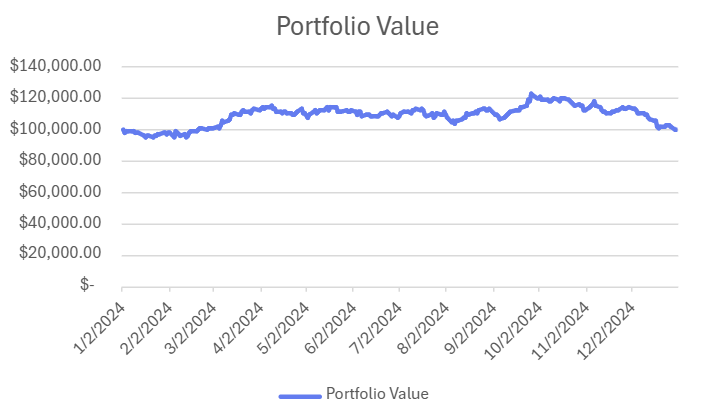

Our daily rebalancing strategy had similar results to our buy and hold strategy; both graphs resemble the same kind of pattern but differ just slightly. We initially lose value in our portfolio due to small fluctuations, hitting a dip early on from January to late February, following this our portfolio gradually begins to increase in value from March to April, after April up until October our portfolio experiences the most volatility, our total value fluctuates but still remains above our initial investment, demonstrating growth in our portfolio's total value following the early dip and represents a positive return eventually making it to our peak value in early October. Our peak value represents a roughly 20% increase in our total value since the start of the year, but like our first strategy this big increase in our portfolio's value is short-lived. Following our peak the total value of our portfolio begins to gradually decrease, by the end of the year our total value stays close to the initial total value sitting just above it at 100,547  


Key Takeaways:  


* Early volatility  



* Mid-year strength/growth



* Mid-year stability  



* Late-year decline

* End of the year positive return  


Overall, this strategy resembled similarities to our buy and hold strategy; we experienced steady fluctuations and for a large portion of the year our portfolio value was steadily increasing, eventually peaking at just above a 20% increase. This strategy produced a balanced and moderately volatile return profile same as our first strategy followed by mid-year growth eventually falling right after reaching our peak but staying just above our initial total value at 100,547

# Buy and Hold for S&P 500
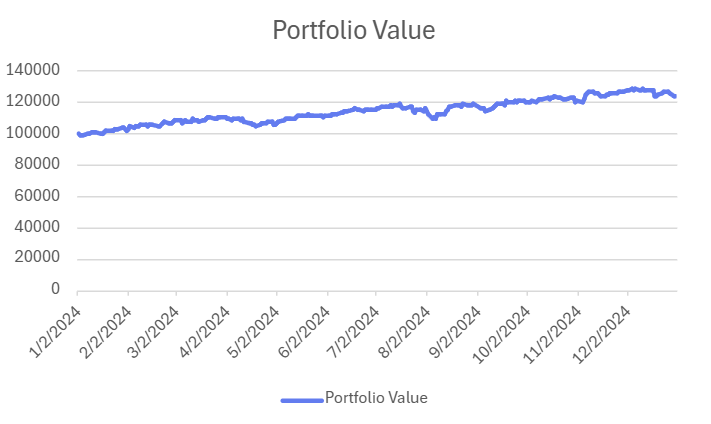

Finally, our buy and hold for S&P 500 strategy had very different results when compared to our other strategies. Unlike our first two strategies, we do not experience an initial dip in the total value of our portfolio. Instead, we are met with steady and consistent growth in our total value. In the span of one year we only experienced two significant dips, one in mid-April and the other in August, but instead of continuing to lose value our total value picked right back up where it left off and continued to increase reaching 123,998, well above our initial value of 100,000 by more than 20%. This is because of the diversification of the S&P 500 and its inclusion of stocks with negative covariance allowing for minimal risk, which is why we see this steady and consistent growth.  


Key Takeaways:  


* Consistent growth  



* Low volatility  



* Resilient to short-term fluctuations

* Over 20% increase in total value at years end  

Overall, this strategy has proven to be the most stable and reliable approach to increasing our portfolio's total value. This strategy delivered steady growth while also experiencing much less fluctuations as opposed to our other strategies that used our 9 selected stocks.

# Conclusion

After analyzing our nine diverse stocks, these were the insights gathered from our models and analysis of investment strategies gathered throughout our project:  

* We used our ‘Optimal stock allocation for different risk levels’ graph to directly pull an adequate risk level of 0.00041. It was the perfect blend of low and high risk, where if we went too low our returns wouldn’t be significant and too high would cause our allocation to focus on just one stock.  

* Before beginning our optimization model, we created a covariance matrix to visually see our stocks relation to each other. Our covariance matrix results were all positive; this is important because now we know all our stocks will move in the same general direction as one increases the other will too and vice versa.  

* In our buy and hold for MPT portfolio our results showed moderate fluctuations but from March to October our portfolio’s total value sits right above our initial total value of 100,000, until reaching its peak in October where we saw 20% increase in our portfolio’s total value. The month that followed, October, is where we began to lose value, eventually making it down to just below our initial total value losing returns in the end.  

* Our daily rebalancing strategy saw almost identical results to our first strategy. We began with a dip in value before experiencing steady growth up until the month of October where our peak was, increasing our portfolio's total value by just over 20% from the initial total value. Right after this peak our portfolio began to decrease in value gradually putting us at just a little below our initial total value, losing returns.  

* In our final strategy, we learned that we earn the best returns approaching this strategy. With investing in the S&P 500 we saw steady and stable growth with minimal fluctuations. By the end of the year, we increased our portfolios total value by over 20%  

* In the end our results pointed to our 3rd strategy being the most profitable option, then our other strategies. What we learned is that the S&P 500 has more diversification with its inclusion of negative covariance stocks. This use of positive and negative covariance stocks cancels out the movement, allowing for smoother returns and less risk whereas our 9 stocks all had positive covariances.